In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import time
import scipy

#Separate import for numpy and jax.numpy to have major felxibility
import jax.numpy as jnp
import numpy as np
from jax import jit,lax,random
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions
from tensorflow_probability.substrates import jax as jtfp
jtfd = jtfp.distributions

np.random.seed(0)

/Users/leopere/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [48]:
sampled_perturbed = np.load('sampled_2D_two_clusters_near.npy')
data = sampled_perturbed[0 : 1000]
#DEFINING NUMBER OF CLUSTERS AND DIMENSION OF DATA
k = 10
d = 2
#Key to store for random generation
rng_key = random.PRNGKey(0)

In [23]:
@jit
def g(x):
    """
    Function to modulate the Wasserstein Distance
    """
    #Shape parameters
    a = 5
    b = 0.5
    return (x <=5 )*x + (1 - (x <=5))*5

@jit
def sample_uniq_vals_fullcond_Wasserstein_NW_log(data,cluster_allocs, mus,covs, h,bij,cov_prop_mu,cov_prop_cov,key):
    """
    Perform one step of the Metropolis Hastings to sample a couple (mu,cov) from N*IW*Wasserstein
    """
    
    
    #Starting point of MH
    mu_old = mus[h]
    cov_old = covs[h]
    log_jac_cov_old = abs(bij.forward_log_det_jacobian( bij.inverse(cov_old) ) )
    
    # Sample the proposal using Bijector and compute jacobian term of transformation
    mu, cov, log_jac_cov,key = sample_from_bijector(mu_old, cov_prop_mu, cov_old, cov_prop_cov,bij,key)
    jac_term = log_jac_cov - log_jac_cov_old
    
    # Compute acceptance rate(and return it for tuning)
    beta = compute_beta_NW_log(data,cluster_allocs,mus,covs, h, mu, cov,mu_old, cov_old,jac_term)
    beta = jnp.minimum(0, beta)
    accept_rate = jnp.exp(beta)
    
    key,subk = random.split(key)
    draw = jtfd.Uniform().sample(seed = subk)
    
    # Select the new or old values 
    logic = jnp.log(draw) >= beta
    ret_mu = logic * jnp.array(mu_old) + (1 - logic)*jnp.array(mu)
    ret_cov = logic * jnp.array(cov_old) + (1 - logic)*jnp.array(cov)


    return ret_mu,ret_cov,accept_rate,key
    
    
@jit
def sample_uniq_vals_prior_Wasserstein_NW_log(mus,covs, h,bij,cov_prop_mu,cov_prop_cov,key):
    """
    Perform one step of the Metropolis Hastings to sample a couple (mu,cov) from N*IW*Wasserstein
    """
    
    # Starting point of MH
    mu_old = mus[h]
    cov_old = covs[h]
    log_jac_cov_old = abs(bij.forward_log_det_jacobian( bij.inverse(cov_old) ) )
    
    # Sample the proposal using Bijector and compute jacobian term of transformation
    mu, cov, log_jac_cov,subk1 = sample_from_bijector(mu_old, cov_prop_mu, cov_old, cov_prop_cov,bij,key)
    jac_term = log_jac_cov - log_jac_cov_old
    
    # Compute acceptance rate(and return it for tuning)
    beta = compute_beta_NW_prior_log(mus,covs, h, mu, cov,mu_old, cov_old,jac_term)
    beta = jnp.minimum(0, beta)
    accept_rate = jnp.exp(beta)
    
    key,subk = random.split(key)
    draw = jtfd.Uniform().sample(seed = subk)
    
    # Select the new or old values 
    logic = jnp.log(draw) >= beta
    ret_mu = logic * jnp.array(mu_old) + (1 - logic)*jnp.array(mu)
    ret_cov = logic * jnp.array(cov_old) + (1 - logic)*jnp.array(cov)


    
    return ret_mu,ret_cov,accept_rate,key
    

@jit
def sample_from_bijector(mu_old, cov_prop_mu, cov_old, cov_prop_cov, bijector,key):
    """
    Sample new mean and covariance matrix through the bijection
    """
    key , subk1 , subk2 = random.split(key,3)
    
    mu = jtfd.MultivariateNormalFullCovariance(mu_old, cov_prop_mu).sample(seed = subk1)
    
    chol = jnp.linalg.cholesky(cov_old)
    vec = bijector.inverse(chol)
    vec_sampl = jtfd.MultivariateNormalFullCovariance(vec,cov_prop_cov).sample(seed = subk2)
    cov_sampl = bijector.forward(vec_sampl)
    cov = jnp.matmul(cov_sampl , jnp.transpose(cov_sampl))
    log_jac = abs(bijector.forward_log_det_jacobian(vec_sampl))
    
    return mu,cov,log_jac,key

@jit
def compute_beta_NW_log(data,cluster_allocs,mus,covs, h, mu, cov,mu_old, cov_old,jac_term):
    """
    Compute Metropolis Hastings term, knowing the proposal is symmetric
    The target is the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_n
    """
    cluster_allocs_expanded = jnp.expand_dims(cluster_allocs,axis = 1)
    nan_vec = jnp.repeat(jnp.array([[jnp.nan,jnp.nan]]),len(cluster_allocs),axis=0)
    clusdata = jnp.where(jnp.concatenate((cluster_allocs_expanded,cluster_allocs_expanded),axis = 1) == h,data,nan_vec)
       
    mu_0 = jnp.zeros(2)
    cov_0 = 10*jnp.eye(2)
    nu_0 = 15
    phi_0 = (nu_0 - 3)*jnp.eye(2)
    
    # NW distribution terms
    num_0 = evaluate_NW_log(mu, cov, mu_0, cov_0, phi_0, nu_0)
    den_0 = evaluate_NW_log(mu_old, cov_old , mu_0, cov_0, phi_0, nu_0)
    
    # Data distribution terms
    num_1 = jnp.nansum(jtfd.MultivariateNormalFullCovariance(mu, cov).log_prob(clusdata))
    den_1 = jnp.nansum(jtfd.MultivariateNormalFullCovariance(mu_old, cov_old).log_prob(clusdata))
    
    # Wasserstein Distance terms
    sum_ = 0
    for j in range(k):
        mu_j = mus[j]
        cov_j = covs[j]
        sum_ = sum_ + jnp.log(compute_Wasserstein(mu , cov , mu_j , cov_j)) - jnp.log(compute_Wasserstein(mu_old , cov_old , mu_j, cov_j))

    #To avoid if    
    mu_j = mus[h]
    cov_j = covs[h]
    sum_ = sum_ - jnp.log(compute_Wasserstein(mu , cov , mu_j , cov_j)) + jnp.log(compute_Wasserstein(mu_old , cov_old , mu_j, cov_j))

    return num_0 + num_1  - den_0 - den_1 + sum_ + jac_term

@jit
def compute_beta_NW_prior_log(mus,covs, h, mu, cov,mu_old, cov_old,jac_term):
    """
    Compute Metropolis Hastings term, knowing the proposal is symmetric
    The target is the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nus the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_"s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nus the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_"n
    """
    
    mu_0 = jnp.zeros(2)
    cov_0 = 10*jnp.eye(2)
    nu_0 = 15
    phi_0 = (nu_0 - 3)*jnp.eye(2)
    
    # NW distribution terms
    num = evaluate_NW_log(mu, cov, mu_0, cov_0, phi_0, nu_0)
    den = evaluate_NW_log(mu_old, cov_old , mu_0, cov_0, phi_0, nu_0)
    
    # Wasserstein Distance terms
    sum_ = 0
    for j in range(k):
        mu_j = mus[j]
        cov_j = covs[j]
        sum_ = sum_ + jnp.log(compute_Wasserstein(mu , cov , mu_j , cov_j)) - jnp.log(compute_Wasserstein(mu_old , cov_old , mu_j, cov_j))

    #To avoid the if in the for cycle, I now subtract/add what i added when j == h
    mu_j = mus[h]
    cov_j = covs[h]
    sum_ = sum_ - jnp.log(compute_Wasserstein(mu , cov , mu_j , cov_j)) + jnp.log(compute_Wasserstein(mu_old , cov_old , mu_j, cov_j))
    
    
    return num  - den + sum_ + jac_term
  
@jit
def evaluate_NW_log(x_mu, x_cov, mu_n, cov_n, phi_n, nu_n):
    """
    Evaluate the likelihood: L[ (x_mu, x_cov) | ( mu_n, cov_n, phi_n, nu_n ) ]
    L = Normal x Inverse Wishart
    """
    W = jnp.linalg.inv(phi_n)
    chol = jnp.linalg.cholesky(W) 
    inv_cov = jnp.linalg.inv(x_cov)

    f1 = jtfd.WishartTriL(df=nu_n.astype(float), scale_tril=chol).log_prob(inv_cov)
    f2 = jtfd.MultivariateNormalFullCovariance(mu_n, cov_n).log_prob(x_mu)
    
    return f1 + f2

@jit
def compute_Wasserstein(mu_1, cov_1, mu_2, cov_2):
    """
    Wasserstein distance for the Gaussian Case, already taking consideration of g() to bound Wasserstein term
    """
    norm = jnp.linalg.norm(mu_1 - mu_2, ord = 2)
    
    #Compute square root of cov_2
    s = jnp.sqrt(jnp.linalg.det(cov_2))
    t = jnp.sqrt(jnp.trace(cov_2) + 2*s)
    sqrt_C2 = 1/t * (cov_2 + s*jnp.eye(2))
    
    C1_sqrt_C2 = jnp.matmul(cov_1,sqrt_C2)
    sqrt_C2_C1_sqrt_C2 = jnp.matmul(sqrt_C2,C1_sqrt_C2)
    
    #Compute square root of sqrt_C2_C1_sqrt_C2
    s = jnp.sqrt(jnp.linalg.det(sqrt_C2_C1_sqrt_C2))
    t = jnp.sqrt(jnp.trace(sqrt_C2_C1_sqrt_C2) + 2*s)
    mat_sqrt = 1/t * (sqrt_C2_C1_sqrt_C2 + s*jnp.eye(2))
    
    trace = jnp.trace(cov_1 + cov_2 - 2 * mat_sqrt)

    # Function g
    return g(norm+trace)

@jit
def update_weights(cluster_allocs, weights, k, alpha,key):

    key, subk = random.split(key)
    n_clus = len(weights)
    n_by_clus = jnp.array([jnp.sum(cluster_allocs == h) for h in range(n_clus)])
    post_params = jnp.ones(n_clus) * alpha + n_by_clus
    return jtfd.Dirichlet(post_params.astype(float)).sample(seed = subk),key

@jit
def update_cluster_allocs(data, weights, mus, covs,key):
    #print(weights)
    key, subk = random.split(key)
    logprobs = jtfd.MultivariateNormalFullCovariance(mus, covs).log_prob(data[:, jnp.newaxis])
    logprobs += jnp.log(weights)
    probs =  jnp.exp(logprobs)/(jnp.sum(jnp.exp(logprobs), axis=1))[:,None]
    return jtfd.Categorical(probs=probs, validate_args=True).sample(seed = subk),key

In [138]:
j = 1
mu_j = mus[j]
cov_j = covs[j]

In [146]:
mu = np.array([-0.288402,  0.387063])
cov = np.array([[0.11108618, 0.2628304],[0.2628304 ,1.3037434]])
print(np.linalg.eigvals(cov))
print(compute_Wasserstein(mu,cov,mu,cov))
print(compute_Wasserstein_slow(mu,cov,mu,cov))



[0.05573417 1.35909541]
-2.3841858e-07
-7.771561e-16


In [24]:
def run_one_gibbs(data, cluster_allocs, mus,covs, weights, alpha,bij,cov_prop_mu,cov_prop_cov,key):
    """
    Run one gibbs sampler iteration
    Takes in input values of the previous iteration and sample the new values from sample_uniq_vals_fullcond, update_weights and update_cluster_allocs
    Returns:   
    
    -cluster_allocs: for every data point, the cluster assigned
    -uniq_vals: array of parameters of the distributions. Matrix has d rows of the type:[mu[0], var[0,0], var[0,1]]
    -weights: array with the weights of the clusters 
     """
    key, subk = random.split(key)
    n_clus = len(weights)
    for h in range(n_clus):
        
        #Extract data assigned to cluster h and sample 
        clusdata = data[cluster_allocs == h]
        if(len(clusdata) != 0):
            mus[h],covs[h], acc_rate,key = sample_uniq_vals_fullcond_Wasserstein_NW_log(data,cluster_allocs, mus,covs, h,bij,cov_prop_mu,cov_prop_cov,key)
        else:
            mus[h],covs[h], acc_rate,key = sample_uniq_vals_prior_Wasserstein_NW_log(mus,covs, h,bij,cov_prop_mu,cov_prop_cov,key)

    #print("mus" + str(mus))
    #print("covs" + str(covs))
    weights,key = update_weights(cluster_allocs ,weights, k, alpha,key)
    #print("weights" + str(weights))
    
    cluster_allocs,key = update_cluster_allocs(data, weights, mus,covs,key)
    #print("Cluster allocs" + str(cluster_allocs))
    
    return cluster_allocs, mus,covs, weights, acc_rate,key

def run_mcmc(data, k, key , niter=1000, nburn=300, thin=5 ): 
    """
    Runs entire MCMC
    Takes in input data, number of clusters, number of iterations, burn-in and thin
    Returns the parameters recorded after burn-in phase
    """

    b = time.time() # only to measure time
    
    #Bijector setup
    jtfb = jtfp.bijectors
    bij = jtfb.Chain([
            jtfb.TransformDiagonal(jtfb.Softplus()),
            jtfb.FillTriangular()])

    #Starting Values
    cluster_allocs = tfd.Categorical(probs=np.ones(k) / k).sample(len(data))
    weights = jnp.ones(k)/k
    alpha = 0.1
    lam = 0.1
    mus = np.array(jtfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis=0), np.eye(d) ).sample(k,seed = key))
    covs = np.array(jtfd.WishartTriL(df=d, scale_tril=tf.linalg.cholesky(np.eye(d)) ).sample(k,seed = key))
    
    #Proposal Covariances
    cov_prop_cov = 0.02 * jnp.eye(3) #covariance matrix for the covariance sampling
    cov_prop_mu = 0.1 * jnp.eye(2)   #covariance matrix for the mean sampling
    
    #Output values
    allocs_out = []
    mus_out = []
    covs_out = []
    weights_out = []
    acc_rates = []
    
    #Useful value
    data_mean = np.mean(data, axis = 0)
    
    #Iterations
    for i in range(niter):
        cluster_allocs, mus,covs, weights, acc_rate,key = run_one_gibbs(
            data, cluster_allocs, mus,covs, weights, alpha,bij,cov_prop_mu,cov_prop_cov,key)
        acc_rates.append(acc_rate)
        
        if i > nburn and i % thin == 0:
            allocs_out.append(cluster_allocs)
            mus_out.append(mus.copy())
            covs_out.append(covs.copy())
            weights_out.append(weights)
            
        if i % 10 == 0 and i > 11:
            a = time.time()
            print("\rIter {0} / {1}".format(i+1, niter) + " Remaining minutes: " + str(round((a-b)*(niter-i)/(60*10) ,1)) , flush=False, end=" ")
            b = time.time()
            print("Acceptance rate: " + str(np.mean(acc_rates[-10:])))
            
    return allocs_out, mus_out,covs_out, weights_out,acc_rates

In [30]:
#RUNNING THE MCMC
start = time.time()
allocs_out, mus_out,covs_out, weights_out,accept_rate_out = run_mcmc(data, k,rng_key , niter = 600,nburn = 200,thin = 1)
end = time.time()
print("Total time: " + str(end-start))

/Users/leopere/anaconda3/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6497: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/Users/leopere/anaconda3/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6497: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/Users/leopere/anaconda3/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:3556: UserWarning: Ex

Iter 21 / 600 Remaining minutes: 1.1 Acceptance rate: nan
Iter 31 / 600 Remaining minutes: 0.0 Acceptance rate: nan
Iter 41 / 600 Remaining minutes: 0.1 Acceptance rate: nan
Iter 51 / 600 Remaining minutes: 0.1 Acceptance rate: nan
Iter 61 / 600 Remaining minutes: 0.1 Acceptance rate: nan
Iter 71 / 600 Remaining minutes: 0.1 Acceptance rate: nan
Iter 81 / 600 Remaining minutes: 0.0 Acceptance rate: nan
Iter 91 / 600 Remaining minutes: 0.0 Acceptance rate: nan
Iter 101 / 600 Remaining minutes: 0.0 Acceptance rate: nan
Iter 111 / 600 Remaining minutes: 0.0 Acceptance rate: nan
Iter 121 / 600 Remaining minutes: 0.0 Acceptance rate: nan
Iter 131 / 600 Remaining minutes: 0.0 Acceptance rate: nan
Iter 141 / 600 Remaining minutes: 0.0 Acceptance rate: nan
Iter 151 / 600 Remaining minutes: 0.0 Acceptance rate: nan
Iter 161 / 600 Remaining minutes: 0.0 Acceptance rate: nan
Iter 171 / 600 Remaining minutes: 0.0 Acceptance rate: nan
Iter 181 / 600 Remaining minutes: 0.0 Acceptance rate: nan
Iter 

9    346
6    340
2    138
5    108
4     68
dtype: int64


<BarContainer object of 5 artists>

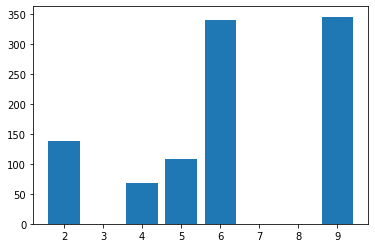

In [31]:
#View the number of points inside each cluster at the final iteration
print(pd.Series(allocs_out[-1]).value_counts())
x, y = np.unique(allocs_out[-1], return_counts=True)
plt.bar(x, y)

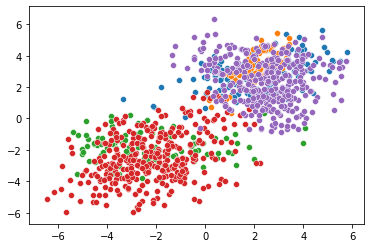

In [32]:
#scatterplot of clusters from last recorded iteration
for h in range(k):
    currd = data[allocs_out[-1] == h]
    sns.scatterplot(x=[elem[0] for elem in currd], y=[elem[1] for elem in currd])

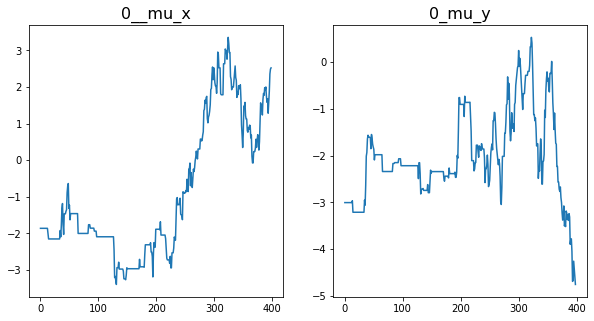

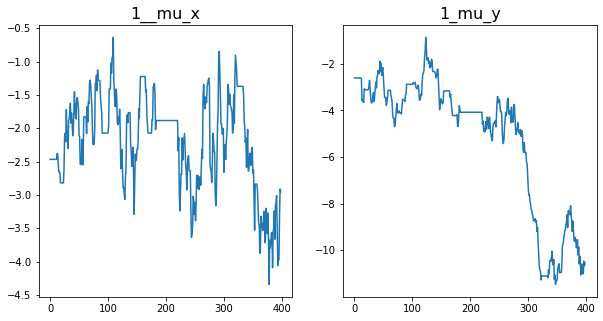

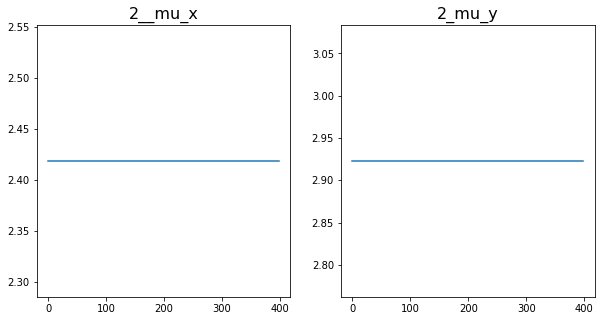

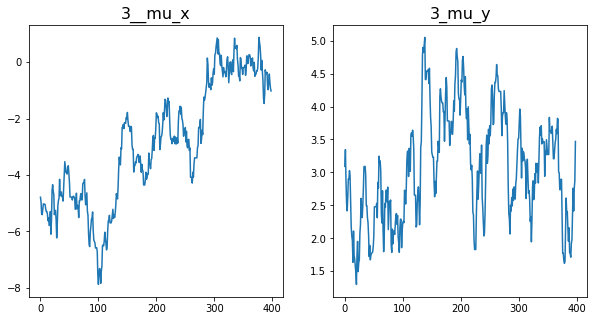

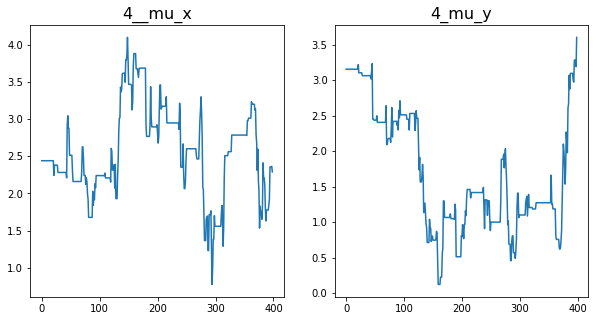

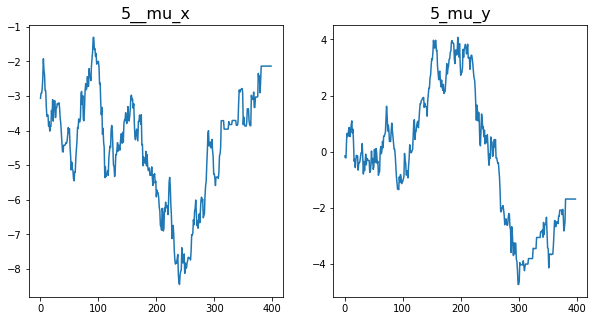

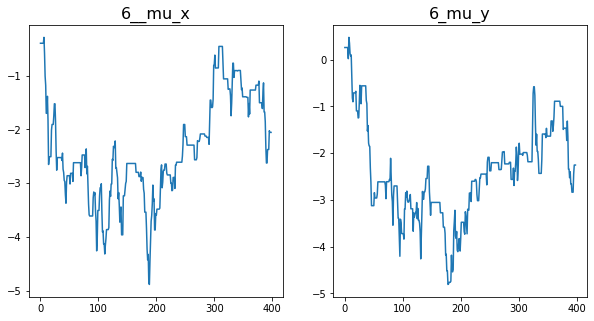

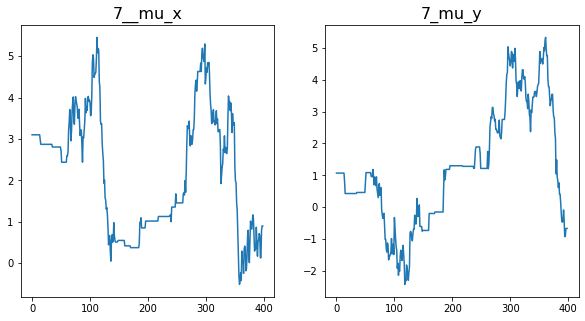

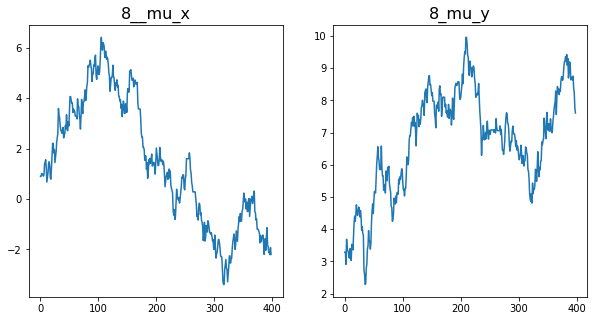

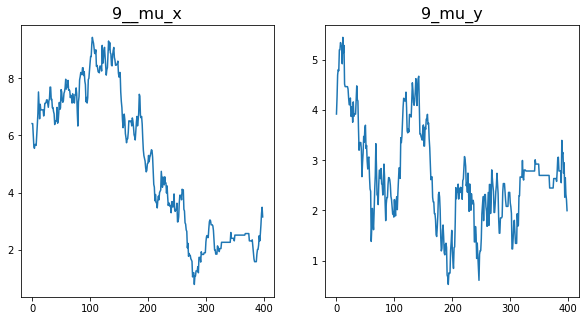

In [33]:
for i in range(k):
    
    #Get mean of the first gaussian component
    first_comp = [mu[i][0] for mu in mus_out]
    second_comp = [mu[i][1] for mu in mus_out]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    axes[0].plot(np.arange(len(first_comp)), first_comp)
    axes[0].set_title(str(i) + "__mu_x", fontsize=16)

    axes[1].plot(np.arange(len(second_comp)), second_comp,)
    axes[1].set_title(str(i) + "_mu_y", fontsize=16)

    plt.show()

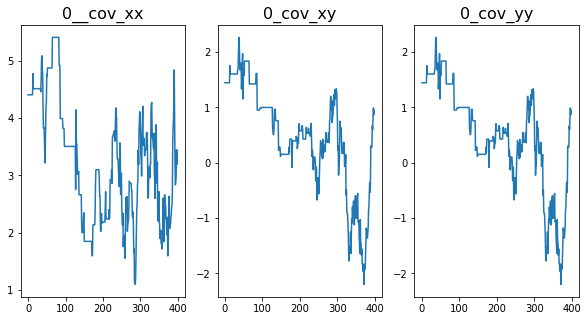

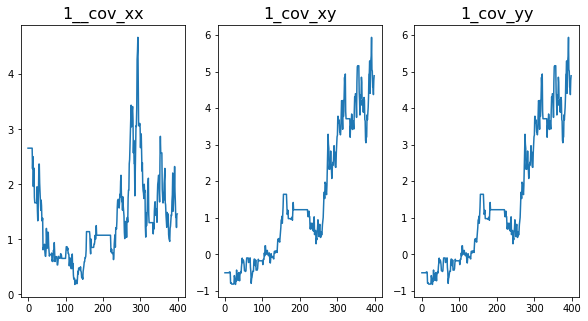

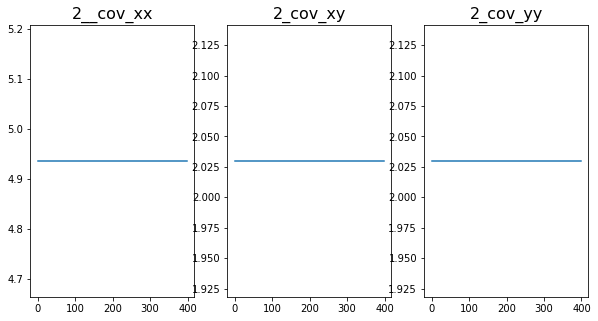

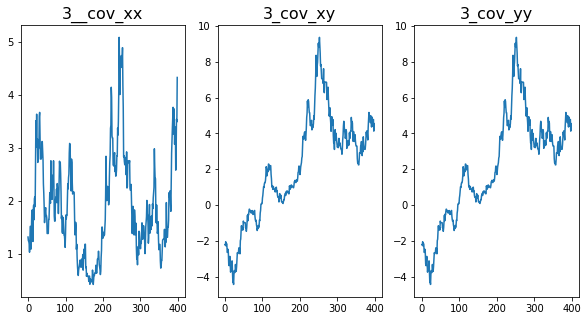

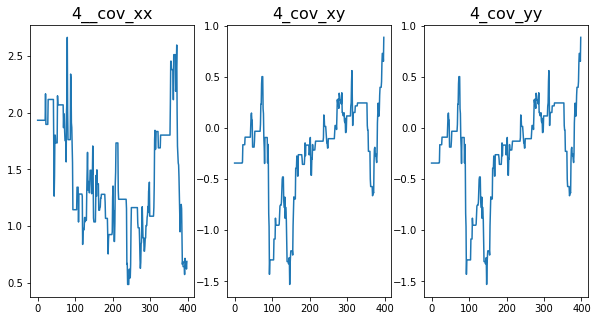

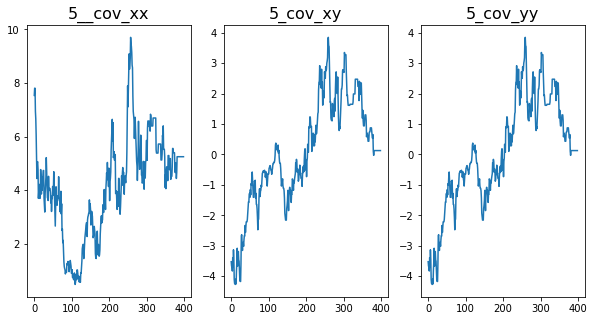

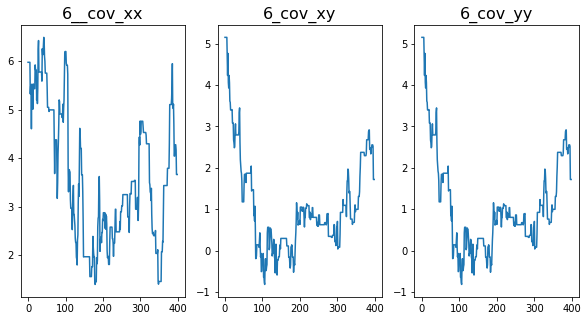

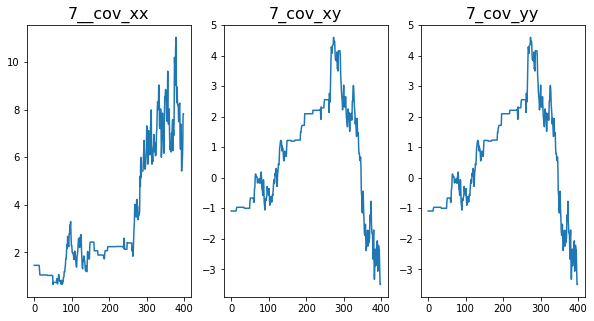

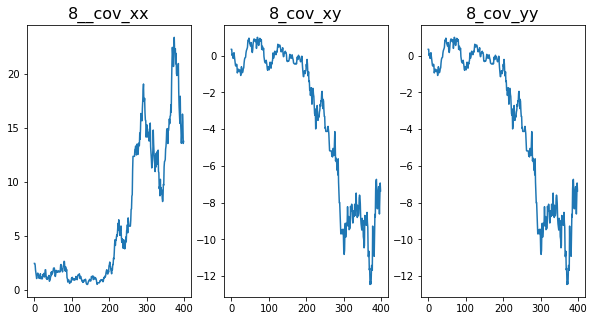

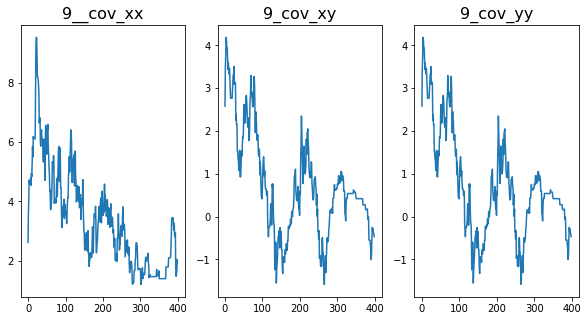

In [34]:
for i in range(k):
    
    #Get mean of the first gaussian component
    first_comp = [covs[i][0,0] for covs in covs_out]
    second_comp = [covs[i][0,1] for covs in covs_out]
    third_comp = [covs[i][1,1] for covs in covs_out]

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

    axes[0].plot(np.arange(len(first_comp)), first_comp)
    axes[0].set_title(str(i) + "__cov_xx", fontsize=16)

    axes[1].plot(np.arange(len(second_comp)), second_comp,)
    axes[1].set_title(str(i) + "_cov_xy", fontsize=16)
    
    axes[2].plot(np.arange(len(third_comp)), second_comp,)
    axes[2].set_title(str(i) + "_cov_yy", fontsize=16)

    plt.show()

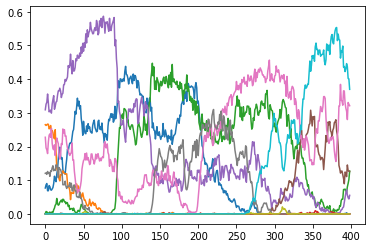

In [35]:
for i in range(k):
    weights = [w[i] for w in weights_out]
    plt.plot(np.arange(len(weights)) , weights)
    

# Speed Comparison

In [55]:
#Slow functions

def sample_uniq_vals_fullcond_Wasserstein_NW_log_slow(clusdata, mus,covs, h,bij,cov_prop_mu,cov_prop_cov):
    """
    Perform one step of the Metropolis Hastings to sample a couple (mu,cov) from N*IW*Wasserstein
    """
    #Starting point of MH
    mu_old = mus[h]
    cov_old = covs[h]
    log_jac_cov_old = abs(bij.forward_log_det_jacobian( bij.inverse(cov_old) ) )
    
    # Sample the proposal using Bijector and compute jacobian term of transformation
    mu, cov, log_jac_cov = sample_from_bijector_slow(mu_old, cov_prop_mu, cov_old, cov_prop_cov,bij)
    jac_term = log_jac_cov - log_jac_cov_old
    
    # Compute acceptance rate(and return it for tuning)
    beta = compute_beta_NW_log_slow(clusdata,mus,covs, h, mu, cov,mu_old, cov_old,jac_term)
    beta = np.minimum(0, beta)
    accept_rate = np.exp(beta)
    
    draw = tfd.Uniform().sample()
    
    # Select the new or old values 
    if(np.log(draw) >= beta):
        return mu_old,cov_old,accept_rate

    else:
        return mu,cov,accept_rate
    
def sample_uniq_vals_prior_Wasserstein_NW_log_slow(mus,covs, h,bij,cov_prop_mu,cov_prop_cov):
    """
    Perform one step of the Metropolis Hastings to sample a couple (mu,cov) from N*IW*Wasserstein
    """
    # Starting point of MH
    mu_old = mus[h]
    cov_old = covs[h]
    log_jac_cov_old = abs(bij.forward_log_det_jacobian( bij.inverse(cov_old) ) )
    
    # Sample the proposal using Bijector and compute jacobian term of transformation
    mu, cov, log_jac_cov = sample_from_bijector_slow(mu_old, cov_prop_mu, cov_old, cov_prop_cov,bij)
    jac_term = log_jac_cov - log_jac_cov_old
    
    # Compute acceptance rate(and return it for tuning)
    beta = compute_beta_NW_prior_log_slow(mus,covs, h, mu, cov,mu_old, cov_old,jac_term)
    beta = np.minimum(0, beta)
    accept_rate = np.exp(beta)
    
    draw = tfd.Uniform().sample()
    
    # Select the new or old values 
    if(np.log(draw) >= beta):
        return np.array(mu_old),np.array(cov_old),accept_rate

    else:
        return np.array(mu),np.array(cov),accept_rate
    

def sample_from_bijector_slow(mu_old, cov_prop_mu, cov_old, cov_prop_cov, bijector):
    """
    Sample new mean and covariance matrix through the bijection
    """
    mu = tfd.MultivariateNormalFullCovariance(mu_old, cov_prop_mu).sample()
    
    chol = np.linalg.cholesky(cov_old)
    vec = bijector.inverse(chol)
    vec_sampl = tfd.MultivariateNormalFullCovariance(vec,cov_prop_cov).sample()
    cov_sampl = bijector.forward(vec_sampl)
    cov = np.matmul(cov_sampl , np.transpose(cov_sampl))
    log_jac = abs(bijector.forward_log_det_jacobian(vec_sampl))
    
    return mu,cov,log_jac

def compute_beta_NW_log_slow(clusdata,mus,covs, h, mu, cov,mu_old, cov_old,jac_term):
    """
    Compute Metropolis Hastings term, knowing the proposal is symmetric
    The target is the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_n
    """
    
    mu_0 = np.zeros(2)
    cov_0 = 10*np.eye(2)
    nu_0 = 15
    phi_0 = (nu_0 - 3)*np.eye(2)
    
    # NW distribution terms
    num_0 = evaluate_NW_log_slow(mu, cov, mu_0, cov_0, phi_0, nu_0)
    den_0 = evaluate_NW_log_slow(mu_old, cov_old , mu_0, cov_0, phi_0, nu_0)
    
    # Data distribution terms
    num_1 = np.sum(tfd.MultivariateNormalFullCovariance(mu, cov).log_prob(clusdata))
    den_1 = np.sum(tfd.MultivariateNormalFullCovariance(mu_old, cov_old).log_prob(clusdata))
    
    # Wasserstein Distance terms
    sum_ = 0
    for j in range(k):
        if(j != h):
            mu_j = mus[j]
            cov_j = covs[j]
            sum_ = sum_ + np.log(compute_Wasserstein_slow(mu , cov , mu_j , cov_j)) - np.log(compute_Wasserstein_slow(mu_old , cov_old , mu_j, cov_j))

    return num_0 + num_1  - den_0 - den_1 + sum_ + jac_term

def compute_beta_NW_prior_log_slow(mus,covs, h, mu, cov,mu_old, cov_old,jac_term):
    """
    Compute Metropolis Hastings term, knowing the proposal is symmetric
    The target is the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nus the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_"s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nus the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_"n
    """
    
    mu_0 = np.zeros(2)
    cov_0 = 10*np.eye(2)
    nu_0 = 15
    phi_0 = (nu_0 - 3)*np.eye(2)
    
    # NW distribution terms
    num = evaluate_NW_log_slow(mu, cov, mu_0, cov_0, phi_0, nu_0)
    den = evaluate_NW_log_slow(mu_old, cov_old , mu_0, cov_0, phi_0, nu_0)
    
    # Wasserstein Distance terms
    sum_ = 0
    for j in range(k):
        if(j != h):
            mu_j = mus[j]
            cov_j = covs[j]
            sum_ = sum_ + np.log(compute_Wasserstein_slow(mu , cov , mu_j , cov_j)) - np.log(compute_Wasserstein_slow(mu_old , cov_old , mu_j, cov_j))

    return num  - den + sum_ + jac_term
  
def evaluate_NW_log_slow(x_mu, x_cov, mu_n, cov_n, phi_n, nu_n):
    """
    Evaluate the likelihood: L[ (x_mu, x_cov) | ( mu_n, cov_n, phi_n, nu_n ) ]
    L = Normal x Inverse Wishart
    """
    W = np.linalg.inv(phi_n)
    chol = np.linalg.cholesky(W) 
    inv_cov = np.linalg.inv(x_cov)

    f1 = tfd.WishartTriL(df=nu_n, scale_tril=chol).log_prob(inv_cov)
    f2 = tfd.MultivariateNormalFullCovariance(mu_n, cov_n).log_prob(x_mu)
    
    return f1 + f2

def compute_Wasserstein_slow(mu_1, cov_1, mu_2, cov_2):
    """
    Wasserstein distance for the Gaussian Case, already taking consideration of g() to bound Wasserstein term
    """
    norm = np.linalg.norm(mu_1 - mu_2, ord = 2)
    sqrt_C2 = scipy.linalg.sqrtm(cov_2)
    C1_sqrt_C2 = np.matmul(cov_1,sqrt_C2)
    sqrt_C2_C1_sqrt_C2 = np.matmul(sqrt_C2,C1_sqrt_C2)
    trace = np.trace(cov_1 + cov_2 - 2 * scipy.linalg.sqrtm(sqrt_C2_C1_sqrt_C2))

    # Function g
    return g(norm+trace)

def update_weights(cluster_allocs, n_clus, k, alpha):

    n_by_clus = np.array([np.sum(cluster_allocs == h) for h in range(n_clus)])
    post_params = np.ones(k) * alpha + n_by_clus
    return tfd.Dirichlet(post_params.astype(float)).sample()

def update_cluster_allocs(data, weights, mus, covs):
    #print(weights)
    logprobs = tfd.MultivariateNormalFullCovariance(mus, covs).log_prob(data[:, np.newaxis])
    logprobs += np.log(weights)
    probs =  np.exp(logprobs)/(np.sum(np.exp(logprobs), axis=1))[:,None]
    return tfd.Categorical(probs=probs, validate_args=True).sample()

In [115]:
#Data to use for comparison
key = rng_key
jtfb = jtfp.bijectors
bij = jtfb.Chain([
        jtfb.TransformDiagonal(jtfb.Softplus()),
        jtfb.FillTriangular()])

#Starting Values
cluster_allocs = tfd.Categorical(probs=np.ones(k) / k).sample(len(data))
weights = jnp.ones(k)/k
alpha = 0.1
lam = 0.1
mus = np.array(jtfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis=0), np.eye(d) ).sample(k,seed = key))
covs = np.array(jtfd.WishartTriL(df=d, scale_tril=tf.linalg.cholesky(np.eye(d)) ).sample(k,seed = key))

#Proposal Covariances
cov_prop_cov = 0.02 * jnp.eye(3) #covariance matrix for the covariance sampling
cov_prop_mu = 0.1 * jnp.eye(2)
h = 3
clusdata = data[cluster_allocs == h]


%timeit sample_uniq_vals_fullcond_Wasserstein_NW_log(data,cluster_allocs, mus,covs, h,bij,cov_prop_mu,cov_prop_cov,key)
%timeit sample_uniq_vals_fullcond_Wasserstein_NW_log_slow(clusdata, mus,covs, h,bij,cov_prop_mu,cov_prop_cov)
%timeit compute_Wasserstein(mus[0], covs[0], mus[3], covs[3])
%timeit compute_Wasserstein_slow(mus[0], covs[0], mus[3], covs[3])
%timeit sample_uniq_vals_prior_Wasserstein_NW_log(mus,covs, h,bij,cov_prop_mu,cov_prop_cov,key)
%timeit sample_uniq_vals_prior_Wasserstein_NW_log_slow(mus,covs, h,bij,cov_prop_mu,cov_prop_cov)


/Users/leopere/anaconda3/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6497: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/Users/leopere/anaconda3/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6497: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/Users/leopere/anaconda3/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:3556: UserWarning: Ex

365 µs ± 117 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
148 ms ± 2.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
The slowest run took 8.26 times longer than the fastest. This could mean that an intermediate result is being cached.
79.6 µs ± 73.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
373 µs ± 6.29 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
The slowest run took 7.23 times longer than the fastest. This could mean that an intermediate result is being cached.
477 µs ± 528 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
179 ms ± 43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
